In [83]:
import pandas as pd
df = pd.read_csv("../assets/TaiwanAirBox032017.csv").set_index("time")
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,8.234563,34.357744,41.250916,41.194228,45.758237,40.424591,36.281097,37.844685,37.835138,44.057510,...,49.152261,55.091967,44.177585,42.569721,34.833622,38.084488,44.854870,46.933081,45.600072,52.152083
2,8.074951,34.455387,39.598679,41.088167,44.970358,39.865248,37.668302,37.439057,37.459381,43.493874,...,48.586604,54.930351,44.329101,41.317196,34.651804,38.463276,45.044264,46.254293,45.387951,51.495833
3,7.918439,34.622896,38.476926,41.116787,44.305423,39.256782,39.073064,37.170659,37.277562,43.126450,...,48.238119,54.718230,44.596777,40.512650,34.616450,38.384003,45.359416,45.830051,45.212193,51.370833
4,7.629787,35.000000,37.800159,41.273497,43.786231,38.687338,38.924916,37.083538,37.134224,42.761130,...,47.738119,54.557624,45.104353,40.027802,34.730447,38.954315,45.789719,45.850253,45.290981,51.386458
5,7.533917,35.494949,37.146960,41.534969,43.316534,38.307347,38.754882,37.050830,37.390285,42.526281,...,47.731806,54.065200,45.814310,39.700529,34.954690,39.820982,46.716991,45.994192,45.903860,51.488542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,47.250000,11.000000,1.500000,4.250000,2.142857,3.000000,3.600000,1.000000,3.571429,1.857143,...,35.125000,43.250000,35.142857,27.250000,20.857143,34.142857,40.800000,32.375000,33.500000,35.000000
741,48.333333,16.333333,2.750000,6.166667,3.500000,4.250000,4.000000,2.500000,5.000000,3.000000,...,40.000000,42.222222,32.571429,19.600000,20.800000,31.500000,38.166667,32.000000,34.500000,37.500000
742,47.666667,18.833333,1.600000,4.857143,2.500000,34.114722,3.750000,2.400000,3.000000,2.400000,...,38.000000,43.000000,32.142857,14.666667,17.666667,19.000000,35.428571,30.333333,34.222222,35.333333


In [84]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import SplineTransformer
import numpy as np

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

N_SPLINES = 5

df_hour = df.assign(hour=(np.arange(len(df)) % 24))
splines = periodic_spline_transformer(24, n_splines=N_SPLINES).fit_transform(df_hour[["hour"]])
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
df_hour_spline = df_hour.merge(splines_df, how = "left", left_on = "hour", right_index = True).drop(columns = "hour")

r2s = []
residuals = []
for target_col in df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")]:
    # get ridgecv r^2
    ridgecv = RidgeCV()
    ridgecv.fit(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col])
    r2s.append(ridgecv.score(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col]))
    # get residuals
    residuals.append(df_hour_spline[target_col] - ridgecv.predict(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]]))

residuals = pd.concat(residuals, axis = 1)
df = residuals
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,-22.358607,-3.350560,12.161376,2.903251,10.606309,7.669913,2.906294,5.778229,2.862718,5.703624,...,-14.522060,-0.928594,-15.851190,6.503137,-2.633867,-13.401032,-24.934932,-6.705772,-14.808317,-5.384072
2,-22.727265,-2.360524,10.930300,3.499912,10.388256,7.813483,4.881180,5.959663,2.980044,5.812601,...,-16.368509,-1.488981,-16.900606,6.007464,-3.328351,-13.653069,-26.097468,-8.412801,-16.047267,-6.503449
3,-23.128789,-1.434996,10.277874,4.272802,10.320302,7.812956,6.904968,6.329243,3.313160,6.117834,...,-17.676725,-2.083351,-17.563483,5.802987,-3.786619,-14.158103,-26.394719,-9.493483,-16.932782,-6.862012
4,-23.641384,-0.537603,10.026263,5.113371,10.327720,7.685863,7.315358,6.823977,3.645640,6.323286,...,-18.955504,-2.630990,-17.696152,5.473077,-3.966214,-13.828486,-26.070894,-9.885183,-17.314644,-6.944375
5,-23.883089,0.136542,9.661715,5.896332,10.216735,7.512023,7.551541,7.209963,4.277438,6.455394,...,-19.699753,-3.536537,-17.316201,4.567265,-3.866668,-13.037447,-24.977780,-10.035869,-16.981274,-6.898693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,16.800354,-29.906074,-27.710055,-34.124133,-33.743746,-32.042789,-30.145067,-31.513493,-32.054437,-37.079967,...,-16.237391,-10.229357,-14.135474,-10.253995,-12.924462,-12.247159,-12.591204,-10.873668,-16.407459,-17.482315
741,17.912608,-24.393869,-26.703857,-32.870130,-32.582703,-30.761704,-30.146775,-30.299858,-30.839440,-36.408756,...,-14.489620,-11.840276,-19.637554,-18.056166,-13.916052,-15.950872,-19.078526,-13.710951,-18.175991,-16.053604
742,17.267435,-21.397685,-27.965938,-34.437476,-33.591742,-0.573554,-30.522488,-30.488432,-32.851188,-37.122370,...,-19.327675,-11.608397,-22.560249,-22.892618,-17.869151,-29.558928,-25.612275,-17.750248,-20.905371,-19.359065


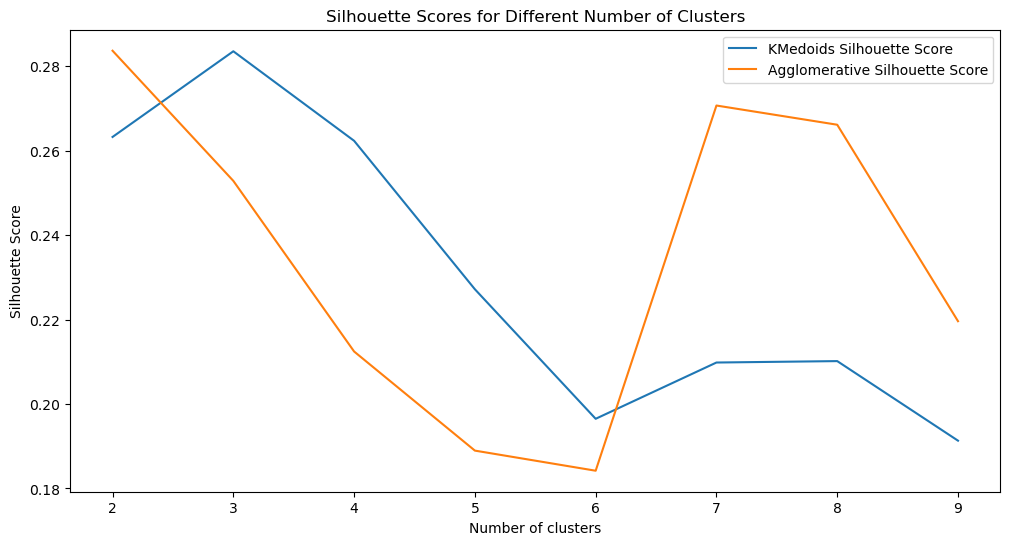

Best number of clusters for KMedoids: 3
Best number of clusters for Agglomerative: 2


In [85]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import numpy as np

def plot_silhouettes_clusters(range_n_clusters, scores, labels: list=None):
    if not isinstance(scores, list):
        scores = [scores]

    if labels is None:
        labels = [f'Model {i}' for i in range(len(scores))]
    
    
    
    # Plotting silhouette scores for each method
    plt.figure(figsize=(12, 6))
    for score, label in zip(scores, labels):
        plt.plot(range_n_clusters, score, label=label)
        # plt.plot(range_n_clusters, silhouette_scores_kmedoids, label='KMedoids Silhouette Score')
        # plt.plot(range_n_clusters, silhouette_scores_hierarchical, label='Agglomerative Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Number of Clusters')
    plt.legend()
    plt.show()


def find_optimal_clusters(data, range_n_clusters, random_state=0, transform=None, distance_matrix_func=None, plot=True,
                          return_all=False):
    """
    Finds the optimal number of clusters using silhouette scores for KMeans, AgglomerativeClustering, and KMedoids.
    Also returns the labels from the best models.
    
    Parameters:
    - data: DataFrame containing the features for clustering.
    - range_n_clusters: A range of cluster numbers to try.
    - random_state: Integer seed for reproducibility.
    - transform: Optional function to transform data before clustering.
    - distance_matrix_func: Optional function to compute a custom distance matrix.
    
    Returns:
    - Best number of clusters and labels for KMedoids and AgglomerativeClustering.
    """
    silhouette_scores_kmedoids = []
    silhouette_scores_hierarchical = []
    labels_kmedoids = []
    labels_hierarchical = []

    transformed_data = data.apply(transform) if transform is not None else data
    distance_matrix = distance_matrix_func(transformed_data) if distance_matrix_func is not None else None

    for n_clusters in range_n_clusters:
        # AgglomerativeClustering
        if distance_matrix is not None:
            hierarchical = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
            cluster_labels_hierarchical = hierarchical.fit_predict(distance_matrix)
        else:
            hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
            cluster_labels_hierarchical = hierarchical.fit_predict(transformed_data.T)
        
        labels_hierarchical.append(cluster_labels_hierarchical)
        silhouette_avg_hierarchical = silhouette_score(data.T, cluster_labels_hierarchical)
        silhouette_scores_hierarchical.append(silhouette_avg_hierarchical)

        # KMedoids or KMeans
        if distance_matrix is not None:
            kmediods = KMedoids(n_clusters=n_clusters, metric="precomputed", random_state=random_state)
            cluster_labels_kmedoids = kmediods.fit_predict(distance_matrix)
        else:
            kmediods = KMeans(n_clusters=n_clusters, random_state=random_state)
            cluster_labels_kmedoids = kmediods.fit_predict(transformed_data.T)
        
        labels_kmedoids.append(cluster_labels_kmedoids)
        silhouette_avg_kmedoids = silhouette_score(data.T, cluster_labels_kmedoids)
        silhouette_scores_kmedoids.append(silhouette_avg_kmedoids)
    
    if plot:
        plot_silhouettes_clusters(range_n_clusters, 
                                  scores = [silhouette_scores_kmedoids, silhouette_scores_hierarchical],
                                  labels = ['KMedoids Silhouette Score', 'Agglomerative Silhouette Score'])

    best_index_kmedoids = np.argmax(silhouette_scores_kmedoids)
    best_index_hierarchical = np.argmax(silhouette_scores_hierarchical)
    
    best_n_clusters_kmedoids = range_n_clusters[best_index_kmedoids]
    best_n_clusters_hierarchical = range_n_clusters[best_index_hierarchical]

    print(f"Best number of clusters for KMedoids: {best_n_clusters_kmedoids}")
    print(f"Best number of clusters for Agglomerative: {best_n_clusters_hierarchical}")

    if return_all:
        return silhouette_scores_kmedoids, labels_kmedoids, silhouette_scores_hierarchical, labels_hierarchical

    labels_kmedoids_best = labels_kmedoids[best_index_kmedoids]
    labels_hierarchical_best = labels_hierarchical[best_index_hierarchical]
    
    return best_n_clusters_kmedoids, labels_kmedoids_best, best_n_clusters_hierarchical, labels_hierarchical_best


# Example usage:
range_n_clusters = list(range(2, 10))
best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42)

In [86]:
def plot_silhouette_scores_3d(configurations):
    fig = plt.figure(figsize=(14, 7))
    
    # KMedoids Silhouette Scores
    ax1 = fig.add_subplot(121, projection='3d')
    x1 = [config['n_clusters'] for config in configurations]
    y1 = [config['n_lags'] for config in configurations]
    z1 = [config['silhouette_score_kmedoids'] for config in configurations]
    
    ax1.scatter(x1, y1, z1, c=z1, cmap='viridis', marker='o')
    ax1.set_title('KMedoids Silhouette Scores')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Number of Lags')
    ax1.set_zlabel('Silhouette Score')
    
    # Hierarchical Clustering Silhouette Scores
    ax2 = fig.add_subplot(122, projection='3d')
    x2 = [config['n_clusters'] for config in configurations]
    y2 = [config['n_lags'] for config in configurations]
    z2 = [config['silhouette_score_hierarchical'] for config in configurations]
    
    ax2.scatter(x2, y2, z2, c=z2, cmap='viridis', marker='o')
    ax2.set_title('Hierarchical Clustering Silhouette Scores')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Number of Lags')
    ax2.set_zlabel('Silhouette Score')
    
    plt.tight_layout()
    plt.show()


def extract_top_k_configurations(df, range_n_clusters, range_n_lags, k, random_state=0, transform=None, distance_matrix_func=None, plot=False):
    configurations = []
    
    for n_lags in range_n_lags:
        # Adjust distance matrix computation for the current number of lags
        distance_matrix = lambda data: distance_matrix_func(data, n_lags) if distance_matrix_func is not None else None
        
        # Retrieve all silhouette scores and labels for the current lag
        silhouette_scores_kmedoids, labels_kmedoids, silhouette_scores_hierarchical, labels_hierarchical = find_optimal_clusters(
            df, range_n_clusters, random_state, transform, 
            distance_matrix_func=distance_matrix, 
            plot=False, return_all=True
        )
        
        for index, n_clusters in enumerate(range_n_clusters):
            configurations.append({
                "n_clusters": n_clusters,
                "n_lags": n_lags,
                "silhouette_score_kmedoids": silhouette_scores_kmedoids[index],
                "labels_kmedoids": labels_kmedoids[index],
                "silhouette_score_hierarchical": silhouette_scores_hierarchical[index],
                "labels_hierarchical": labels_hierarchical[index]
            })
    
    if plot:
        plot_silhouette_scores_3d(configurations)
    
    # Sort and select top KMedoids configurations
    top_kmedoids = sorted(configurations, key=lambda x: x['silhouette_score_kmedoids'], reverse=True)[:k]

    # Sort and select top Hierarchical configurations
    top_hierarchical = sorted(configurations, key=lambda x: x['silhouette_score_hierarchical'], reverse=True)[:k]

    # Combine the top configurations into a single list using extend
    top_configurations = []
    top_configurations.extend(top_kmedoids)
    top_configurations.extend(top_hierarchical)
    
    # Print or return the top k configurations, depending on your needs
    for config in top_configurations:
        print(f"Number of Clusters: {config['n_clusters']}, Number of Lags: {config['n_lags']}, "
              f"Silhouette Score KMedoids: {config['silhouette_score_kmedoids']}, "
              f"Silhouette Score Hierarchical: {config['silhouette_score_hierarchical']}")
        # For detailed inspection, you can also access config['labels_kmedoids'] and config['labels_hierarchical']
    
    return top_configurations


In [87]:
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings

def get_max_order(df):
    warning_message_pattern = "An unsupported index was provided and will be ignored when e.g. forecasting."

    max_lags = []

    for column in df.columns:
        series_non_missing = df[column].dropna()  # Drop missing values for the current column
        n_obs_non_missing = len(series_non_missing)
        maxlag = min(10, n_obs_non_missing // 10)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ValueWarning, message=warning_message_pattern)
            mod = ar_select_order(df[column], maxlag=maxlag, trend='c', ic='bic')
        optimal_lags = len(mod.ar_lags) if mod.ar_lags is not None else 0
        max_lags.append(optimal_lags)

    # Find the maximum number of lags across all columns
    max_order = max(max_lags)
    return max_order

n_lags = get_max_order(df)

print(f"Maximum number of lags across all columns: {n_lags}")


Maximum number of lags across all columns: 6


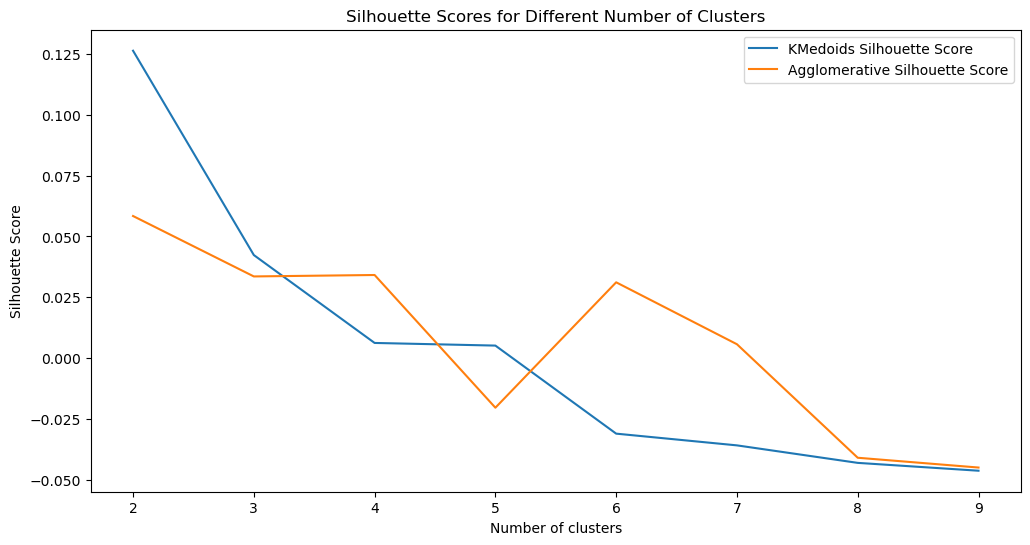

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2


In [88]:
import pandas as pd
from statsmodels.tsa.stattools import acf

def calculate_acf(series, n_lags=5):
    """
    Calculate the Autocorrelation Function (ACF) for a given pandas Series.

    Parameters:
    - series: Pandas Series to calculate ACF for.
    - n_lags: Number of lags to calculate ACF for.

    Returns:
    - A pandas Series of ACF values for lags 1 to n_lags.
    """
    # Ensure series has no missing values and enough data points
    if series.dropna().shape[0] > n_lags: 
        acf_values = acf(series.dropna(), nlags=n_lags, fft=True)[1:] # Exclude lag 0
        return pd.Series(acf_values, index=[f'L{i}' for i in range(1, n_lags+1)])
    else: # Return NaNs if not enough data
        return pd.Series([pd.NA] * n_lags, index=[f'{i}' for i in range(1, n_lags+1)])


acf_df = df.apply(calculate_acf, n_lags=n_lags)

acf_df.head()
best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, 
                                                       transform=lambda data: calculate_acf(data, n_lags=n_lags))

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6
Best number of clusters for KMedoids: 2
Best number of clusters f

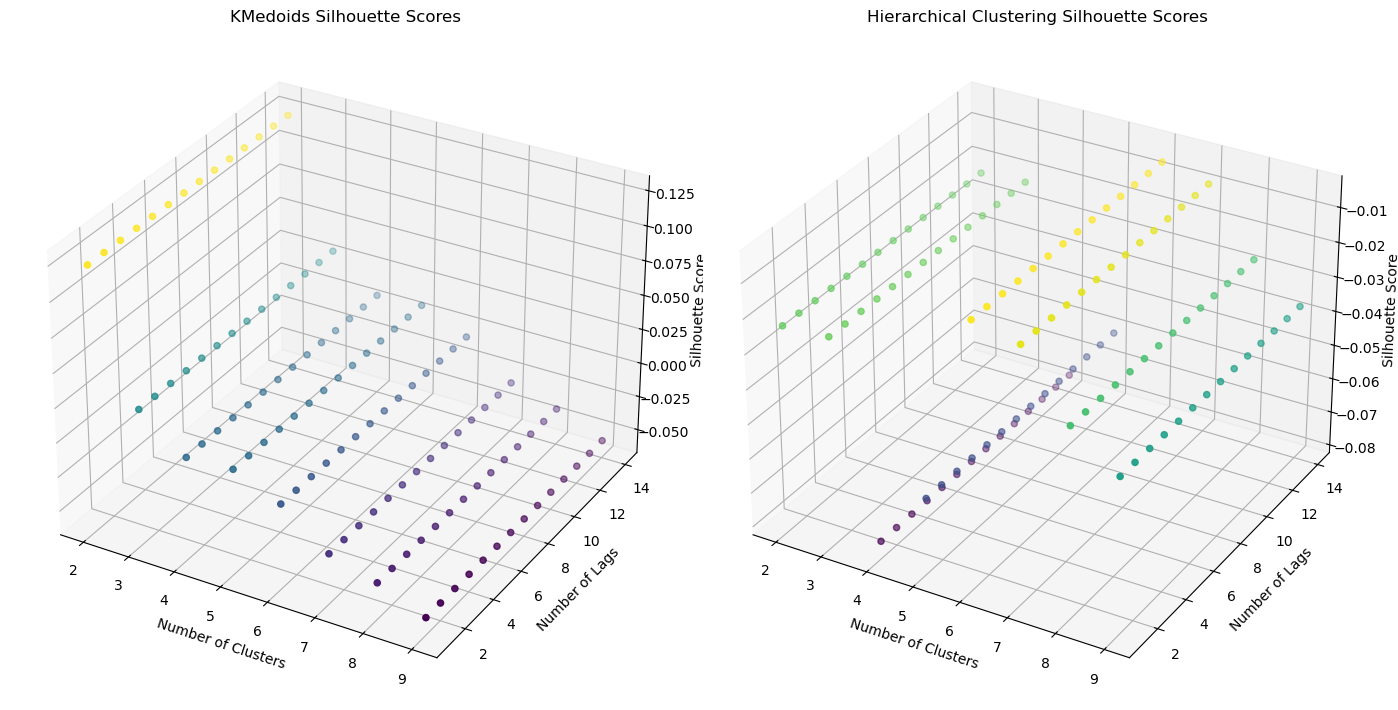

Number of Clusters: 2, Number of Lags: 1, Silhouette Score KMedoids: 0.12263180494610909, Silhouette Score Hierarchical: -0.02316168724004037
Number of Clusters: 2, Number of Lags: 2, Silhouette Score KMedoids: 0.12263180494610909, Silhouette Score Hierarchical: -0.02316168724004037
Number of Clusters: 2, Number of Lags: 3, Silhouette Score KMedoids: 0.12263180494610909, Silhouette Score Hierarchical: -0.02316168724004037
Number of Clusters: 2, Number of Lags: 4, Silhouette Score KMedoids: 0.12263180494610909, Silhouette Score Hierarchical: -0.02316168724004037
Number of Clusters: 2, Number of Lags: 5, Silhouette Score KMedoids: 0.12263180494610909, Silhouette Score Hierarchical: -0.02316168724004037
Number of Clusters: 6, Number of Lags: 1, Silhouette Score KMedoids: -0.005753530424193763, Silhouette Score Hierarchical: -0.006202725137658859
Number of Clusters: 6, Number of Lags: 2, Silhouette Score KMedoids: -0.005753530424193763, Silhouette Score Hierarchical: -0.006202725137658859


In [89]:
# Example usage
range_n_clusters = list(range(2, 10))
range_n_lags = range(1, 15)  # Example range of lags
k = 5  # Number of top configurations to extract
top_k_configurations = extract_top_k_configurations(df, range_n_clusters, range_n_lags, k, random_state=42, transform=calculate_acf, plot=True)
# plot_silhouette_scores_3d(top_k_configurations)

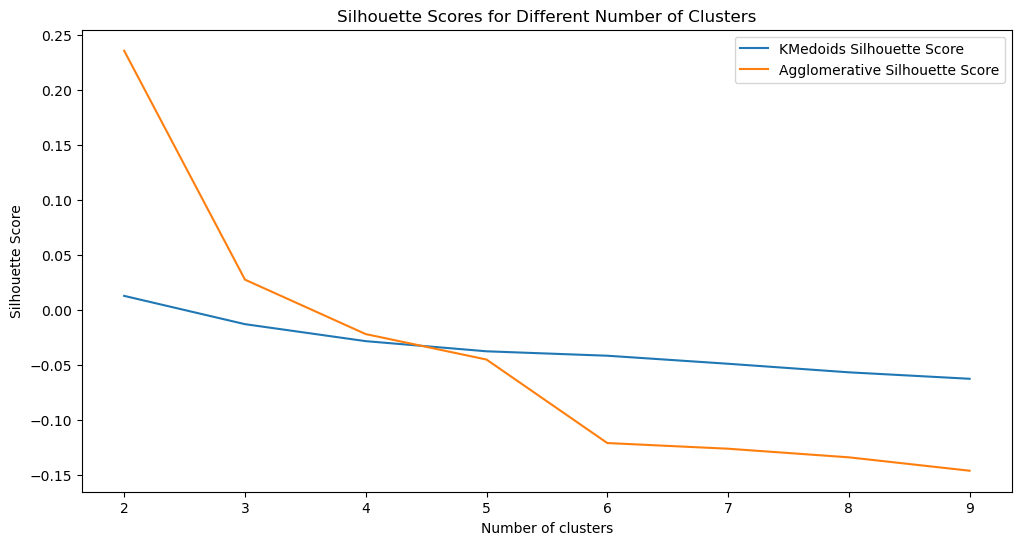

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2


In [90]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

def fit_ar_and_extract_coeffs(series, n_lags=5, trend='c'):
    """
    Fits an AR model to a pandas Series and extracts the AR coefficients.
    
    Parameters:
    - series: Pandas Series to fit the AR model to.
    - n_lags: Number of lags for the AR model.
    - trend: Trend specification for the AR model ('n' for no trend, 'c' for constant).
    
    Returns:
    - A pandas Series of AR coefficients.
    """
    warning_message_pattern = "An unsupported index was provided and will be ignored when e.g. forecasting."

    if series.dropna().shape[0] > n_lags:  # Ensure enough data points
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ValueWarning, message=warning_message_pattern)
            ar_model = AutoReg(series.dropna(), lags=n_lags, trend=trend)
            ar_model_fitted = ar_model.fit()
        
        # Extract AR coefficients, skipping the intercept if trend is not 'n'
        coeffs = ar_model_fitted.params if trend == 'n' else ar_model_fitted.params[1:]
        coeffs.index = [f'L{i}' for i in range(1, len(coeffs)+1)]
        return coeffs
    else:
        # Return NaNs if not enough data
        return pd.Series([pd.NA] * n_lags, index=[f'L{i}' for i in range(1, n_lags+1)])

ar_coeffs_df = df.apply(fit_ar_and_extract_coeffs, n_lags=n_lags, trend='c')

ar_coeffs_df.head()

best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, 
                                                       transform=lambda data: fit_ar_and_extract_coeffs(data, n_lags=n_lags))


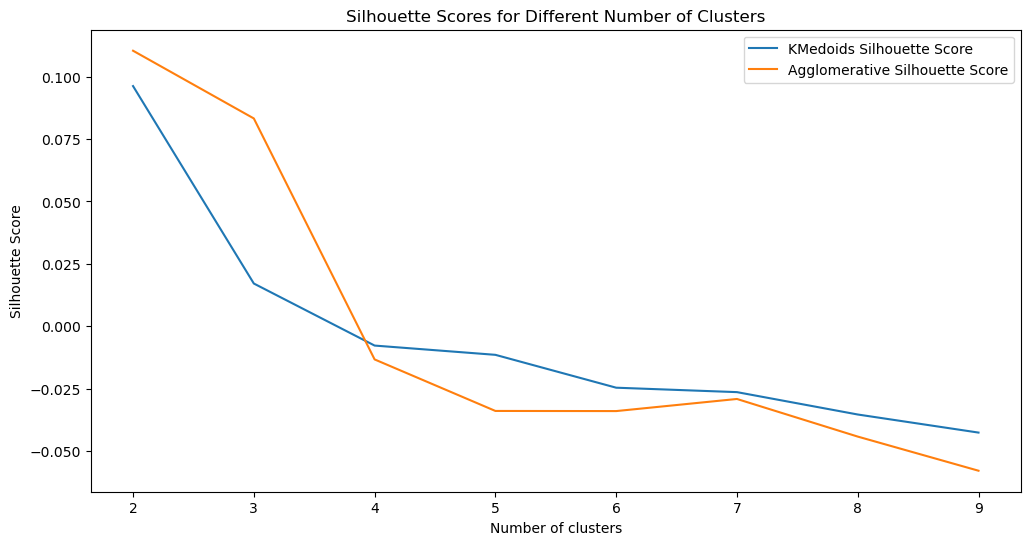

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2


In [91]:
def calculate_r_squared_autocorrelation(series, max_lag):
    # Compute autocorrelation values
    autocorr_values = acf(series, nlags=max_lag, fft=True)
    
    r_squared_values = []
    for i in range(1, max_lag + 1):
        # Construct the autocorrelation matrix up to lag i
        R_X_i = np.array([[autocorr_values[np.abs(j-k)] for k in range(i)] for j in range(i)])
        
        # Invert the autocorrelation matrix
        R_X_i_inv = np.linalg.inv(R_X_i)
        
        # Construct the autocorrelation vector up to lag i
        rho_X_1_i = np.array(autocorr_values[1:i+1]).reshape(-1, 1)
        
        # Calculate r^2 using the given formula
        r_squared = np.dot(np.dot(rho_X_1_i.T, R_X_i_inv), rho_X_1_i).item()
        r_squared_values.append(r_squared)
        
    return r_squared_values

def acf_dissimilarity(df, max_lag):
    r_squared_df = df.apply(lambda x: calculate_r_squared_autocorrelation(x, max_lag))
    
    # Sum of the logarithms for to avoid rounding errors
    log_sum = np.log(1 - r_squared_df).sum()

    # Exponentiate to negate log.
    geometric_mean_exp = np.exp(log_sum / (max_lag + 1)).to_numpy()

    acf_distance = np.abs(geometric_mean_exp[:, np.newaxis] - geometric_mean_exp[np.newaxis, :])
    return acf_distance

best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, transform=None, 
                                                         distance_matrix_func=lambda data: acf_dissimilarity(data, max_lag=n_lags))


Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 3
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 2
Best number of clusters for KMedoids: 2
Best number of clusters f

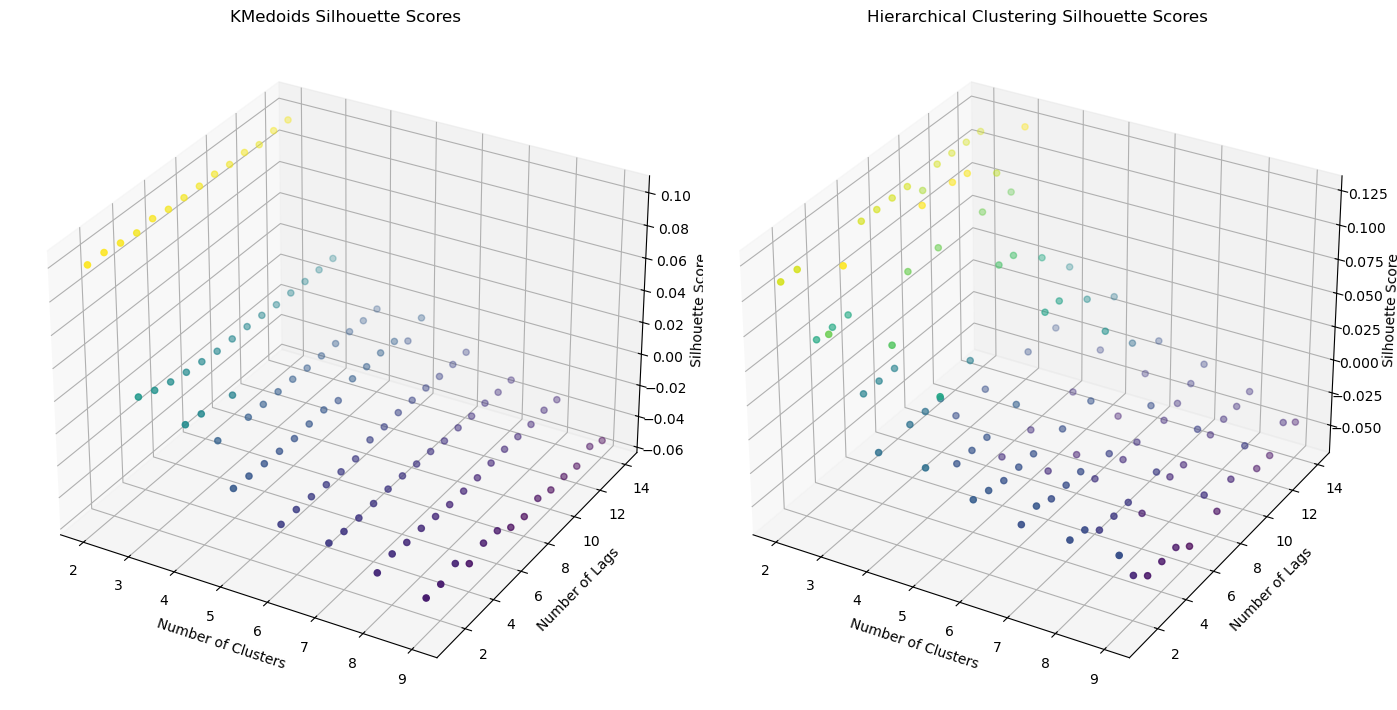

Number of Clusters: 2, Number of Lags: 1, Silhouette Score KMedoids: 0.09912439654403228, Silhouette Score Hierarchical: 0.11045330988356512
Number of Clusters: 2, Number of Lags: 2, Silhouette Score KMedoids: 0.09912439654403228, Silhouette Score Hierarchical: 0.11045330988356512
Number of Clusters: 2, Number of Lags: 5, Silhouette Score KMedoids: 0.09776182669466063, Silhouette Score Hierarchical: 0.05099942368133433
Number of Clusters: 2, Number of Lags: 3, Silhouette Score KMedoids: 0.0975119910587062, Silhouette Score Hierarchical: 0.05099942368133433
Number of Clusters: 2, Number of Lags: 9, Silhouette Score KMedoids: 0.09666733808249105, Silhouette Score Hierarchical: 0.11045330988356512
Number of Clusters: 3, Number of Lags: 2, Silhouette Score KMedoids: 0.024284767483114488, Silhouette Score Hierarchical: 0.12240912075947503
Number of Clusters: 3, Number of Lags: 7, Silhouette Score KMedoids: 0.017109552363385336, Silhouette Score Hierarchical: 0.12240912075947503
Number of Cl

In [92]:
# Example usage
range_n_clusters = list(range(2, 10))
range_n_lags = range(1, 15)  # Example range of lags
k = 5  # Number of top configurations to extract
acf_top_k_configurations = extract_top_k_configurations(df, range_n_clusters, range_n_lags, k, random_state=42, distance_matrix_func=acf_dissimilarity, plot=True)
# plot_silhouette_scores_3d(top_k_configurations)

In [93]:
acf_distance = acf_dissimilarity(df, n_lags)
acf_distance

array([[0.        , 0.04125012, 0.06376107, ..., 0.09295543, 0.08851021,
        0.06485801],
       [0.04125012, 0.        , 0.02251096, ..., 0.13420555, 0.12976033,
        0.10610812],
       [0.06376107, 0.02251096, 0.        , ..., 0.1567165 , 0.15227129,
        0.12861908],
       ...,
       [0.09295543, 0.13420555, 0.1567165 , ..., 0.        , 0.00444522,
        0.02809743],
       [0.08851021, 0.12976033, 0.15227129, ..., 0.00444522, 0.        ,
        0.02365221],
       [0.06485801, 0.10610812, 0.12861908, ..., 0.02809743, 0.02365221,
        0.        ]])

In [94]:
from statsmodels.tsa.stattools import ccf
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D

def compute_autocorrelation_norms(df, h):
    norms = {}
    for column in df.columns:
        series = df[column].dropna()  # Ensure no NaN values
        ccf_values = ccf(series, series, adjusted=True)
        first = list(reversed(ccf_values[1:h]))
        second = ccf_values[:h]
        autocorr_values = np.concatenate([first, second])
        norms[column] = np.linalg.norm(autocorr_values)
    return norms

def compute_cc_matrix(df, h):
    n = df.shape[1]  # Number of series
    cc_matrix = np.zeros((n, n))
    
    # Precompute autocorrelation norms for each series
    autocorr_norms = compute_autocorrelation_norms(df, h)
    

    for i in tqdm(range(n)):
        for j in range(i+1, n):  # The matrix is symmetric
            series_i = df.iloc[:, i].dropna()
            series_j = df.iloc[:, j].dropna()
            
            # Compute cross-correlation for lags -h to h
            first = list(reversed(ccf(series_j, series_i, adjusted=True)[1:h]))
            second = ccf(series_i, series_j, adjusted=True)[:h]
            cross_correlations = np.concatenate([first, second])
            norm_xy = np.linalg.norm(cross_correlations)
            
            # Use precomputed autocorrelation norms
            norm_xx = autocorr_norms[df.columns[i]]
            norm_yy = autocorr_norms[df.columns[j]]

            # Compute DCC,h dissimilarity
            cc_ij = 1 - (norm_xy**2) / (norm_xx * norm_yy)
            cc_matrix[i, j] = cc_matrix[j, i] = cc_ij
            
    return cc_matrix


# best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, transform=None, 
#                                                          distance_matrix_func=lambda data: compute_cc_matrix(data, n_lags // 2))


In [95]:
results = {
    "acf": acf_top_k_configurations
    }

import json




  0%|          | 0/516 [00:00<?, ?it/s]

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 6


  0%|          | 0/516 [00:00<?, ?it/s]

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 8


  0%|          | 0/516 [00:00<?, ?it/s]

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 8


  0%|          | 0/516 [00:00<?, ?it/s]

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 9


  0%|          | 0/516 [00:00<?, ?it/s]

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 8


  0%|          | 0/516 [00:00<?, ?it/s]

Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 8


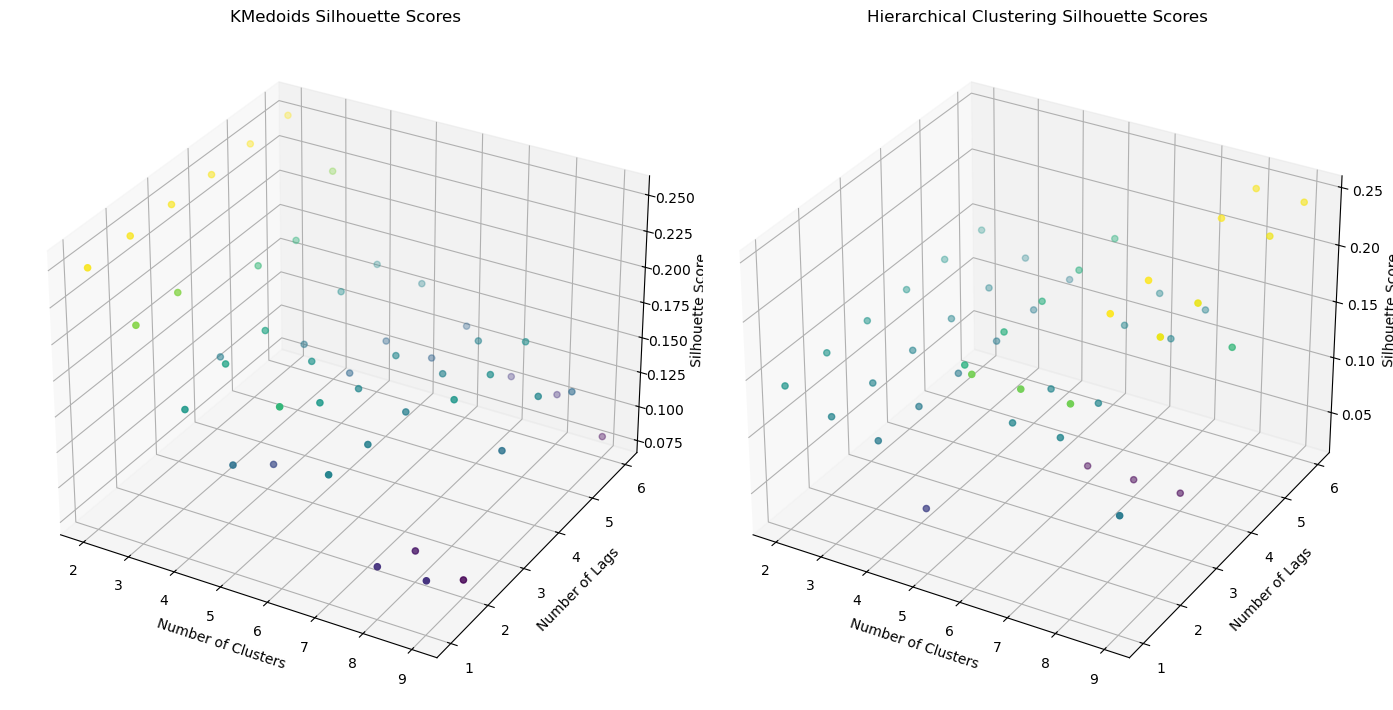

Number of Clusters: 2, Number of Lags: 6, Silhouette Score KMedoids: 0.25071716224223545, Silhouette Score Hierarchical: 0.14088157554745184
Number of Clusters: 2, Number of Lags: 5, Silhouette Score KMedoids: 0.25041936649901864, Silhouette Score Hierarchical: 0.14088157554745184
Number of Clusters: 2, Number of Lags: 3, Silhouette Score KMedoids: 0.24917934720067259, Silhouette Score Hierarchical: 0.14088157554745184
Number of Clusters: 2, Number of Lags: 4, Silhouette Score KMedoids: 0.24917934720067259, Silhouette Score Hierarchical: 0.14088157554745184
Number of Clusters: 2, Number of Lags: 1, Silhouette Score KMedoids: 0.2487866551363795, Silhouette Score Hierarchical: 0.14088157554745184
Number of Clusters: 8, Number of Lags: 2, Silhouette Score KMedoids: 0.08857124292142271, Silhouette Score Hierarchical: 0.24429243111138266
Number of Clusters: 8, Number of Lags: 3, Silhouette Score KMedoids: 0.16980539145964552, Silhouette Score Hierarchical: 0.24429243111138266
Number of Clus

In [96]:
# Example usage
range_n_clusters = list(range(2, 10))
range_n_lags = range(1, 7)  # Example range of lags
k = 5  # Number of top configurations to extract
cc_top_k_configurations = extract_top_k_configurations(df, range_n_clusters, range_n_lags, k, random_state=42, distance_matrix_func=compute_cc_matrix, plot=True)
# plot_silhouette_scores_3d(top_k_configurations)

In [97]:
# Example usage
cc_matrix = compute_cc_matrix(df, n_lags // 2)
cc_matrix

  0%|          | 0/516 [00:00<?, ?it/s]

array([[0.        , 0.98750191, 0.97471241, ..., 0.9994635 , 0.99738331,
        0.99794404],
       [0.98750191, 0.        , 0.12386873, ..., 0.99933889, 0.99656488,
        0.99402995],
       [0.97471241, 0.12386873, 0.        , ..., 0.99827411, 0.99324497,
        0.99845309],
       ...,
       [0.9994635 , 0.99933889, 0.99827411, ..., 0.        , 0.09128663,
        0.36291586],
       [0.99738331, 0.99656488, 0.99324497, ..., 0.09128663, 0.        ,
        0.29098509],
       [0.99794404, 0.99402995, 0.99845309, ..., 0.36291586, 0.29098509,
        0.        ]])

In [98]:
import os
os.environ['R_HOME'] = '/usr/lib/R/'

import rpy2
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()

base = importr('base')
utils = importr('utils')
SLBDD = importr('SLBDD')

In [99]:
def compute_gcc_matrix(df, n_lags):
    r_df = pandas2ri.py2rpy(df)
    result = SLBDD.GCCmatrix(r_df, n_lags)
    gcc_distance_matrix = result.rx2('DM')
    return gcc_distance_matrix

# best_kmedoids, labels_kmedoids, best_hierarchical, labels_hierarchical = find_optimal_clusters(df, range_n_clusters, random_state=42, transform=None, 
#                                                          distance_matrix_func=lambda data: compute_gcc_matrix(data, n_lags))


Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 9
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 8
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 9
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 9
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 9
Best number of clusters for KMedoids: 2
Best number of clusters for Agglomerative: 9


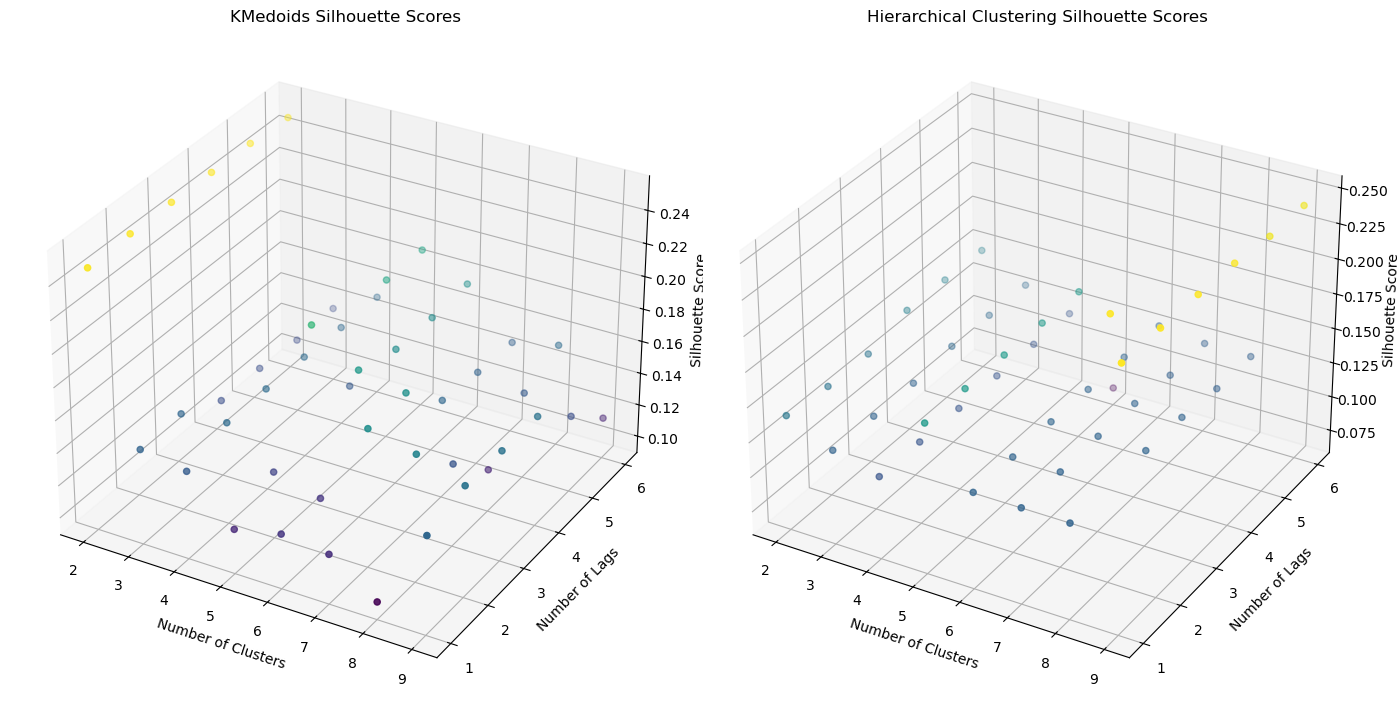

Number of Clusters: 2, Number of Lags: 4, Silhouette Score KMedoids: 0.24974467896953445, Silhouette Score Hierarchical: 0.14677817420471084
Number of Clusters: 2, Number of Lags: 5, Silhouette Score KMedoids: 0.24974467896953445, Silhouette Score Hierarchical: 0.14677817420471084
Number of Clusters: 2, Number of Lags: 3, Silhouette Score KMedoids: 0.24972298446362534, Silhouette Score Hierarchical: 0.13783230756588083
Number of Clusters: 2, Number of Lags: 2, Silhouette Score KMedoids: 0.24932050907594172, Silhouette Score Hierarchical: 0.13783230756588083
Number of Clusters: 2, Number of Lags: 6, Silhouette Score KMedoids: 0.24837748751270688, Silhouette Score Hierarchical: 0.14677817420471084
Number of Clusters: 8, Number of Lags: 2, Silhouette Score KMedoids: 0.167646548893998, Silhouette Score Hierarchical: 0.24575682477546074
Number of Clusters: 9, Number of Lags: 1, Silhouette Score KMedoids: 0.1498363416004014, Silhouette Score Hierarchical: 0.24566087194101888
Number of Cluste

In [100]:
# Example usage
range_n_clusters = list(range(2, 10))
range_n_lags = range(1, 7)  # Example range of lags
k = 5  # Number of top configurations to extract
gcc_top_k_configurations = extract_top_k_configurations(df, range_n_clusters, range_n_lags, k, random_state=42, distance_matrix_func=compute_gcc_matrix, plot=True)
# plot_silhouette_scores_3d(top_k_configurations)

In [101]:
gcc_distance_matrix = compute_gcc_matrix(df, n_lags)
gcc_distance_matrix

array([[0.        , 0.98846146, 0.98830393, ..., 0.99238794, 0.99294962,
        0.9945085 ],
       [0.98846146, 0.        , 0.48591262, ..., 0.98927033, 0.98923131,
        0.98684328],
       [0.98830393, 0.48591262, 0.        , ..., 0.98143887, 0.98801229,
        0.99200075],
       ...,
       [0.99238794, 0.98927033, 0.98143887, ..., 0.        , 0.41356037,
        0.78069334],
       [0.99294962, 0.98923131, 0.98801229, ..., 0.41356037, 0.        ,
        0.69739192],
       [0.9945085 , 0.98684328, 0.99200075, ..., 0.78069334, 0.69739192,
        0.        ]])

In [102]:
import json

results = {
    "acf": acf_top_k_configurations,
    "cc": cc_top_k_configurations,
    "gcc": gcc_top_k_configurations
}

def serialize_configurations(configurations):
    """
    Convert clustering configurations to a serializable format for JSON, including handling lists and NumPy arrays.
    
    Args:
    - configurations (dict): A dictionary where keys are configuration names or identifiers,
      and values are the configurations, which may include non-serializable types like NumPy arrays and lists containing such types.
    
    Returns:
    - dict: A dictionary with the same structure as `configurations` but with all values converted
      to serializable types.
    """
    def serialize_value(value):
        """Recursively serialize any value to a JSON-serializable format."""
        if hasattr(value, 'tolist'):
            # Convert NumPy array to list
            return value.tolist()
        elif isinstance(value, list):
            # Recursively serialize each item in the list
            return [serialize_value(item) for item in value]
        elif isinstance(value, dict):
            # Recursively serialize dictionary values
            return {k: serialize_value(v) for k, v in value.items()}
        else:
            # Assume the value is already serializable (e.g., int, float, str)
            return value

    # Serialize each configuration in the dictionary
    return {key: serialize_value(config) for key, config in configurations.items()}


# Serialize and save to JSON
with open('../out/clustering_results.json', 'w') as f:
    json.dump(serialize_configurations(results), f)
